In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special as sci_spe
import healpy as hp
import time
from astropy.time import TimeDelta
 
import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from mapmaking.planck_timeline import ExternalData2Timeline
import mapmaking.systematics as acq
from mapmaking.frequency_acquisition import get_preconditioner
from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators import (
    CartesianEquatorial2GalacticOperator,
    CartesianEquatorial2HorizontalOperator,
    CartesianHorizontal2EquatorialOperator,
    CartesianGalactic2EquatorialOperator,
    SamplingHorizontal,
    SphericalEquatorial2GalacticOperator,
    SphericalGalactic2EquatorialOperator,
    SphericalEquatorial2HorizontalOperator,
    SphericalHorizontal2EquatorialOperator)
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, Spherical2HealpixOperator
from pyoperators import *
from qubic.samplings import create_random_pointings, QubicSampling, hor2equ

import tools.cg as cg




comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# QUBIC Initialisation

In [2]:
with open('params.yml', "r") as stream:
    params = yaml.safe_load(stream)
nside_sky = params['Sky']['nside']
print(params)
def get_ultrawideband_config():
    
    """
    
    Method that pre-compute UWB configuration.

    """
    
    nu_up = 247.5
    nu_down = 131.25
    nu_ave = np.mean(np.array([nu_up, nu_down]))
    delta = nu_up - nu_ave

    return nu_ave, 2*delta/nu_ave
def get_dict():

    """

    Method to modify the qubic dictionary.

    """

    nu_ave, delta_nu_over_nu = get_ultrawideband_config()

    args = {'npointings':params['QUBIC']['npointings'], 
            'nf_recon':params['QUBIC']['nrec'], 
            'nf_sub':params['QUBIC']['fsub'] * params['QUBIC']['nrec'], 
            'nside':params['Sky']['nside'], 
            'MultiBand':True, 
            'period':1, 
            'RA_center':params['QUBIC']['RA_center'], 
            'DEC_center':params['QUBIC']['DEC_center'],
            'filter_nu':nu_ave*1e9, 
            'noiseless':False, 
            'comm':comm, 
            'dtheta':params['QUBIC']['dtheta'],
            'nprocs_sampling':1, 
            'nprocs_instrument':size,
            'photon_noise':True, 
            'nhwp_angles':params['QUBIC']['nhwp_angles'], 
            'effective_duration':3, 
            'filter_relative_bandwidth':delta_nu_over_nu, 
            'type_instrument':'wide', 
            'TemperatureAtmosphere150':None, 
            'TemperatureAtmosphere220':None,
            'EmissivityAtmosphere150':None, 
            'EmissivityAtmosphere220':None, 
            'detector_nep':float(params['QUBIC']['detector_nep']), 
            'synthbeam_kmax':params['QUBIC']['synthbeam_kmax']}

    args_mono = args.copy()
    args_mono['nf_recon'] = 1
    args_mono['nf_sub'] = 1

    ### Get the default dictionary
    dictfilename = 'dicts/pipeline_demo.dict'
    d = qubic.qubicdict.qubicDict()
    d.read_from_file(dictfilename)
    dmono = d.copy()
    for i in args.keys():

        d[str(i)] = args[i]
        dmono[str(i)] = args_mono[i]


    return d, dmono
d = get_dict()[0]

{'path_out': 'test', 'Sky': {'CMB': {'cmb': [False, 1], 'r': 0, 'Alens': 1}, 'Foregrounds': {'Dust': False, 'Synchrotron': False}, 'nside': 256}, 'QUBIC': {'npointings': 10000, 'fsub': 4, 'nrec': 2, 'iteration': 1, 'ndet': 0, 'npho150': 0, 'npho220': 0, 'synthbeam_kmax': 1, 'detector_nep': 4.7e-17, 'nhwp_angles': 3, 'dtheta': 15, 'type': 'two', 'covcut': 0, 'kappa': 0, 'convolution': False, 'reconvolution_after_MM': False, 'bandpass_correction': True, 'RA_center': 0, 'DEC_center': -57, 'planck_regularization': False}, 'Spectrum': {'dl': 30, 'lmin': 40, 'lmax': 511, 'aposize': 10}, 'PCG': {'maxiter': 100, 'tol': 1e-20}, 'Data': {'datafilename': 'MC', 'planck': True, 'level_external_data_noise': 1}, 'Pipeline': {'mapmaking': True, 'spectrum': False}, 'bandwidth_qubic': 0.25, 'bandwidth_planck': 0.2, 'nb_integration': 100}


In [3]:
Qacq = acq.QubicFullBandSystematic(d, params['QUBIC']['fsub'] * params['QUBIC']['nrec'], Nrec=params['QUBIC']['nrec'])
#joint = acq.JointAcquisitionFrequencyMapMaking(d, params['QUBIC']['type'], params['QUBIC']['nrec'], params['QUBIC']['fsub'] * params['QUBIC']['nrec'])

#H = joint.qubic.get_operator(fwhm=np.zeros(params['QUBIC']['fsub'] * params['QUBIC']['nrec']))
H = Qacq.get_operator(fwhm=np.zeros(params['QUBIC']['fsub'] * params['QUBIC']['nrec']))

You asked 10000 pointings with repeat strategy so I will provide 3333 pointings repeated 3 times.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB

Info apcnb2325: Allocating (9919008,9) elements = 1.33024263381958 GiB in FSRRotation3dMatrix.__init__.


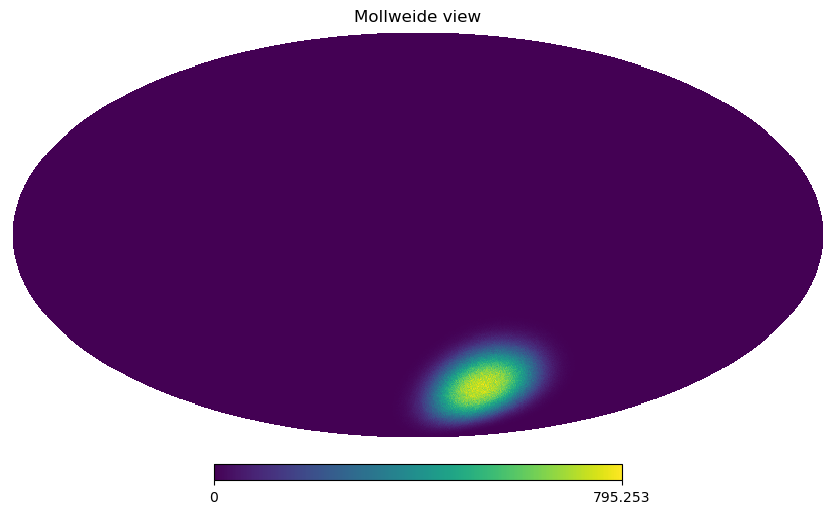

In [4]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.subacqs[0].get_coverage()
npix_qubic=0
for i in coverage:
    if i!=0:
        npix_qubic+=1
covnorm = coverage / coverage.max()
seenpix = covnorm > params['QUBIC']['covcut']
fsky = seenpix.astype(float).sum() / seenpix.size
coverage_cut = coverage.copy()
coverage_cut[~seenpix] = 1

mask = np.ones(12*params['Sky']['nside']**2)
mask[seenpix] = params['QUBIC']['kappa']

#invN = joint.get_invntt_operator(mask=mask)
invN = Qacq.get_invntt_operator()

center = np.array([0, -57])

def _get_preconditionner():
    conditionner = np.ones((params['QUBIC']['nrec'], 12*params['Sky']['nside']**2, 3))
        
    for i in range(conditionner.shape[0]):
        for j in range(conditionner.shape[2]):
            conditionner[i, :, j] = 1/coverage_cut
            
    return get_preconditioner(conditionner)

hp.mollview(coverage)

# RADEC Projection V0

Projection naïve de l'atm, je pense que cela n'a pas de sens : je projète une carte de dimension L sur l'ensemble de la voute céleste.
Il faudrait faire la même chose mais en gardant en tête les échelles de grandeurs de l'atm vue par QUBIC avec 30<el<70

In [5]:
nside_atm = nside_sky
N = 12*256**2
N_test = npix_qubic
print(N, N_test)

def find_divisors_numpy(number):
    numbers = np.arange(1, number + 1)
    divisors = numbers[number % numbers == 0]
    return divisors

divisors = find_divisors_numpy(N)
print(len(divisors), divisors)

786432 83650
38 [     1      2      3      4      6      8     12     16     24     32
     48     64     96    128    192    256    384    512    768   1024
   1536   2048   3072   4096   6144   8192  12288  16384  24576  32768
  49152  65536  98304 131072 196608 262144 393216 786432]


In [6]:
Nx = divisors[int(len(divisors)/2)]
Ny = divisors[int(len(divisors)/2)-1]
print(Nx*Ny - N, Nx, Ny)

0 1024 768


In [7]:
maximum_length = 300      # Correlation length for water vapor density (m)
h = 4869                  # Height for QUBIC (m)
L = 3000                  # Atm size (m)
Lz = 1000                 # Atm depth (m)
L_QUBIC = h * np.sin(np.radians(15)) 

x_list = np.linspace(-L, L, Nx)
y_list = np.linspace(-L, L, Ny)

# Mean water vapor density as a function of height

def water_vapor_density(z, rho_0=1, h0=1000):
    '''
    Water vapor density as a function of geopotential height h
    rho_0: Reference mean density of water vapor in g/m³
    h0: The half height for water vapor in m
    '''
    return rho_0 * np.exp(-np.log(2) * (z - 5190) / h0)

# Generate spatial frequency in Fourier space
k_distrib_y = np.fft.fftfreq(Nx, d=2*L/Nx) * 2*np.pi
k_distrib_x = np.fft.fftfreq(Ny, d=2*L/Ny) * 2*np.pi
kx, ky = np.meshgrid(k_distrib_x, k_distrib_y)
k_mag = np.sqrt(kx**2 + ky**2)

# We will use the Kolomogorov power spectrum to simulate turbulences in atmosphere
def kolmogorov_spectra_2d(k):
    return (maximum_length**(-2) + np.abs(k)**2)**(-8/6)

# We normalize to have the integral of the power spectrum over all k egal to 1
res, _ = scipy.integrate.quad(kolmogorov_spectra_2d, np.min(k_mag), np.max(k_mag))

def normalized_kolmogorov_2d(k):  
    return kolmogorov_spectra_2d(k)/res

water_vapor_0 = water_vapor_density(h, 1, 1000)

z = np.linspace(0, 10000)
rho_0 = 1
h0 = 2770 

# Compute the Kolmogorov power spectrum 
P_k = normalized_kolmogorov_2d(k_mag)

# Generate spatial fluctuations using the spatial power spectrum
phi = np.random.uniform(0, 2*np.pi, size=(Nx, Ny))
delta_rho_k = np.sqrt(P_k) * np.exp(1j * phi)

# Apply inverse Fourier transform to obtain spatial fluctuations
delta_rho = np.fft.ifft2(delta_rho_k).real

PWV = 5 #mm^-1
z = np.linspace(h, h+Lz, N)
mean_water_vapor = water_vapor_density(h + Lz)
sigma_PWV = 0.5 #mm^-1
sigma_rho = sigma_PWV / 3 * mean_water_vapor

# Takes into account the cutoff of high wavenumbers
sigma_simulated = sigma_rho * np.sqrt(scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, np.min(k_distrib_x), np.max(k_distrib_x))[0] 
                                       / scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, -maximum_length, maximum_length)[0])

rho_2d = np.zeros((Nx, Ny))

mean_delta = np.mean(delta_rho)
var_delta = np.var(delta_rho)

rho_2d += mean_water_vapor + sigma_simulated * (delta_rho - mean_delta) / np.sqrt(var_delta)

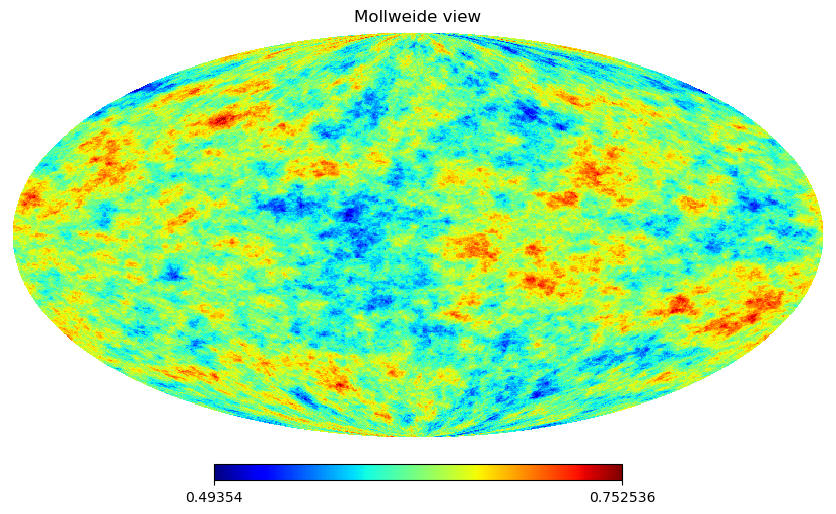

In [8]:
n_pixels = hp.nside2npix(nside_atm)
rho_hp_v0 = np.zeros(n_pixels)

for i in range(n_pixels):
    ipix_lonlat = hp.pix2ang(nside_atm, i, lonlat=True)
    lon_index = int(ipix_lonlat[0] / 360 * rho_2d.shape[1])
    lat_index = int(ipix_lonlat[1] / 180 * rho_2d.shape[0])
    rho_hp_v0[i] = rho_2d[lat_index, lon_index]

hp.mollview(rho_hp_v0, cmap='jet')


# Atm 2d

In [9]:
Nx, Ny = 4000, 4000
print(npix_qubic - Nx*Ny)

maximum_length = 300      # Correlation length for water vapor density (m)
h = 4869                  # Height for QUBIC (m)
L = 10000                  # Atm size (m)
Lz = 1000                 # Atm depth (m)
L_QUBIC = h * np.sin(np.radians(15)) 

x_list = np.linspace(-L, L, Nx)
y_list = np.linspace(-L, L, Ny)

# Mean water vapor density as a function of height

def water_vapor_density(z, rho_0=1, h0=1000):
    '''
    Water vapor density as a function of geopotential height h
    rho_0: Reference mean density of water vapor in g/m³
    h0: The half height for water vapor in m
    '''
    return rho_0 * np.exp(-np.log(2) * (z - 5190) / h0)

# Generate spatial frequency in Fourier space
k_distrib_y = np.fft.fftfreq(Nx, d=2*L/Nx) * 2*np.pi
k_distrib_x = np.fft.fftfreq(Ny, d=2*L/Ny) * 2*np.pi
kx, ky = np.meshgrid(k_distrib_x, k_distrib_y)
k_mag = np.sqrt(kx**2 + ky**2)

# We will use the Kolomogorov power spectrum to simulate turbulences in atmosphere
def kolmogorov_spectra_2d(k):
    return (maximum_length**(-2) + np.abs(k)**2)**(-8/6)

# We normalize to have the integral of the power spectrum over all k egal to 1
res, _ = scipy.integrate.quad(kolmogorov_spectra_2d, np.min(k_mag), np.max(k_mag))

def normalized_kolmogorov_2d(k):  
    return kolmogorov_spectra_2d(k)/res

water_vapor_0 = water_vapor_density(h, 1, 1000)

z = np.linspace(0, 10000)
rho_0 = 1
h0 = 2770 

# Compute the Kolmogorov power spectrum 
P_k = normalized_kolmogorov_2d(k_mag)

# Generate spatial fluctuations using the spatial power spectrum
phi = np.random.uniform(0, 2*np.pi, size=(Nx, Ny))
delta_rho_k = np.sqrt(P_k) * np.exp(1j * phi)

# Apply inverse Fourier transform to obtain spatial fluctuations
delta_rho = np.fft.ifft2(delta_rho_k).real

PWV = 5 #mm^-1
z = np.linspace(h, h+Lz, N)
mean_water_vapor = water_vapor_density(h + Lz)
sigma_PWV = 0.5 #mm^-1
sigma_rho = sigma_PWV / 3 * mean_water_vapor

# Takes into account the cutoff of high wavenumbers
sigma_simulated = sigma_rho * np.sqrt(scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, np.min(k_distrib_x), np.max(k_distrib_x))[0] 
                                       / scipy.integrate.quad(lambda k : kolmogorov_spectra_2d(k) * k**2, -maximum_length, maximum_length)[0])

rho_2d = np.zeros((Nx, Ny))

mean_delta = np.mean(delta_rho)
var_delta = np.var(delta_rho)

rho_2d += mean_water_vapor + sigma_simulated * (delta_rho - mean_delta) / np.sqrt(var_delta)
rho_2d_flatten = rho_2d.flatten()

-15916350


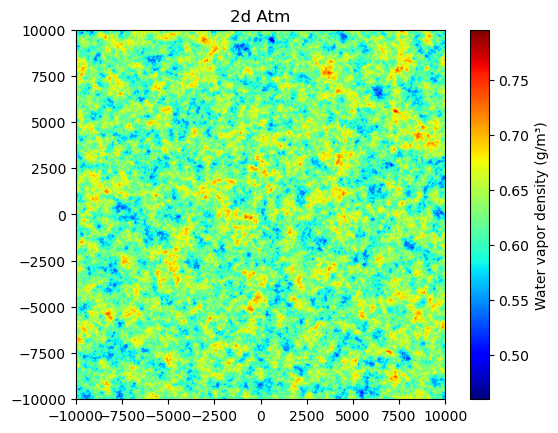

In [10]:
plt.figure()
plt.imshow(rho_2d, extent=[-L, L, -L, L], cmap='jet')
plt.title('2d Atm')
plt.colorbar(format = '%.2f', label = 'Water vapor density (g/m³)')
plt.show()

# RADEC Projection

Projection à partir de la class sampling initialisée avec la config QUBIC

In [11]:
def azel_to_horizontal_plane(az, el, h):
    x = h / np.sin(el) * np.cos(el) * np.cos(az)
    y = h / np.sin(el) * np.cos(el) * np.sin(az)
    return x, y

def find_closest_element(arr, variable):
    idx = np.abs(arr - variable).argmin()
    return idx, arr[idx]

def get_atm_value_2d(rho_2d, az, el, x_list, y_list, height):
    x_atm, y_atm = azel_to_horizontal_plane(az, el, height)
    ind_x, x_pos = find_closest_element(x_list, x_atm)
    ind_y, y_pos = find_closest_element(y_list, y_atm)
    return x_pos, y_pos, rho_2d[ind_y, ind_x]

In [12]:
sampling = qubic.get_pointing(d)
azimuth = sampling.azimuth
elevation = sampling.elevation

ipixel = sampling.healpix(nside_sky)
npixel = 12 * nside_sky ** 2
hit = np.histogram(ipixel, bins=npixel, range=(0, npixel))[0]

You asked 10000 pointings with repeat strategy so I will provide 3333 pointings repeated 3 times.


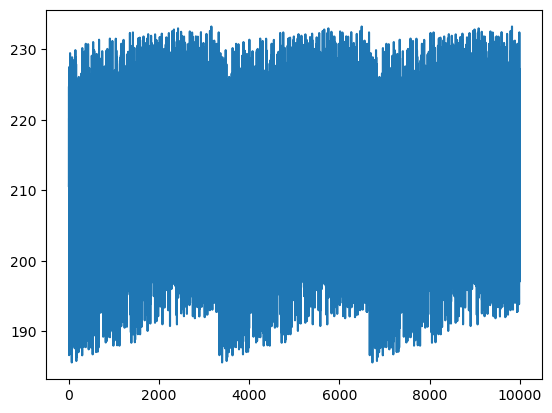

In [13]:
plt.plot(azimuth)

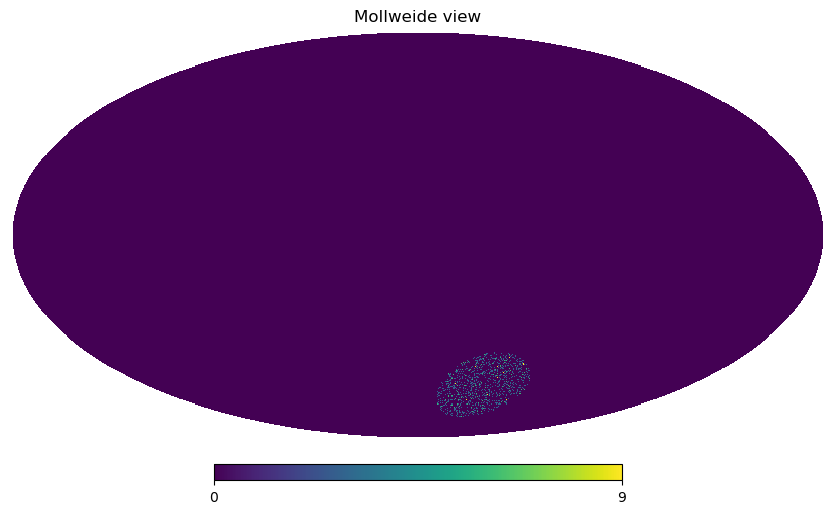

In [14]:
hp.mollview(hit)

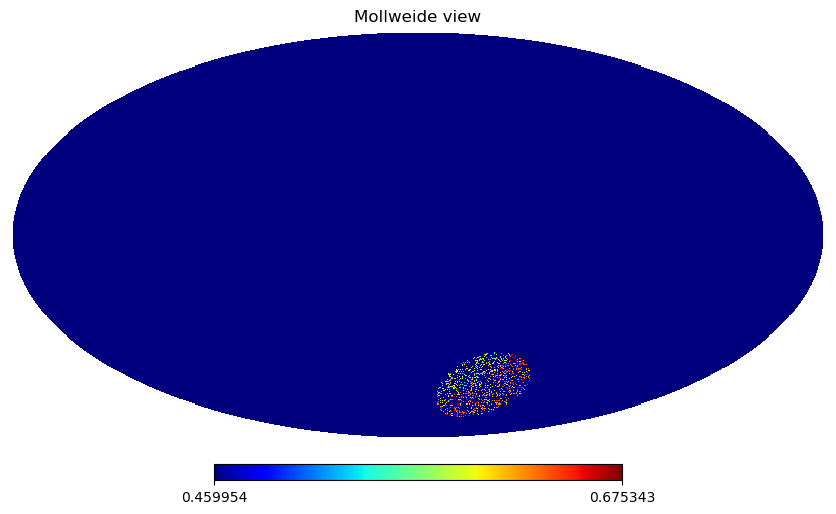

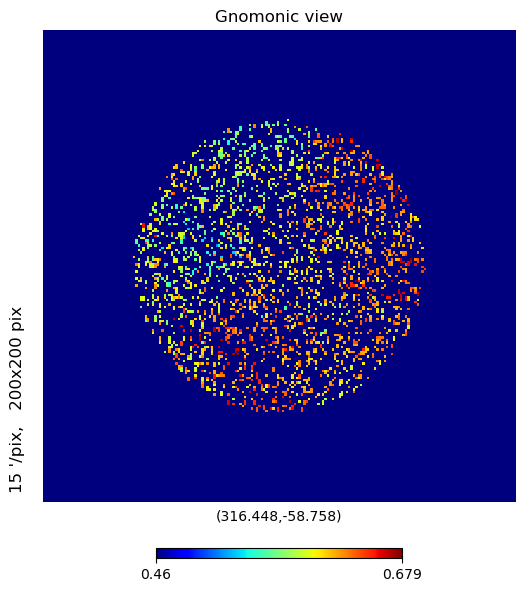

In [15]:
rho_hp = np.zeros(npixel)
for i in range(len(ipixel)):
    rho_hp[int(ipixel[i])] = get_atm_value_2d(rho_2d, np.radians(azimuth[i]), np.radians(elevation[i]), x_list, y_list, Lz)[2]
hp.mollview(rho_hp, min=np.min(rho_2d), cmap='jet')
hp.gnomview(rho_hp, rot=qubic.equ2gal(center[0], center[1]), reso=15, min=np.min(rho_2d), cmap='jet')

# RADEC Projection V2

Idem mais en augmentant le pointage et en appelant create_random_pointings

In [16]:
sampling_test = create_random_pointings(center, 10000, 15, d['hwp_stepsize'], d['date_obs'], d['period'], d['latitude'], d['longitude'],d['seed'])
azimuth = sampling_test.azimuth
elevation = sampling_test.elevation

In [17]:
sampling_test

QubicSampling((10000,), 
    index=[   0    1    2 ... 9997 9998 9999],
    angle_hwp=[60 60 45 ... 60 60 45],
    azimuth=[215.69991503 202.97188267 220.77544415 ... 200.37893899 220.9377,
    elevation=[39.38626833 56.65787068 37.66592413 ... 31.5482579  14.37329619
,
    equatorial=[[339.12721381 -56.35764262]
 [ 12.48898913 -53.50100626]
 [334.7,
    galactic=[[333.0263752  -52.15383358]
 [303.42799553 -63.62581628]
 [340.0,
    masked=False,
    pitch=[290.08873307 194.97146669 316.39923231 ... 152.80530101 349.2810)

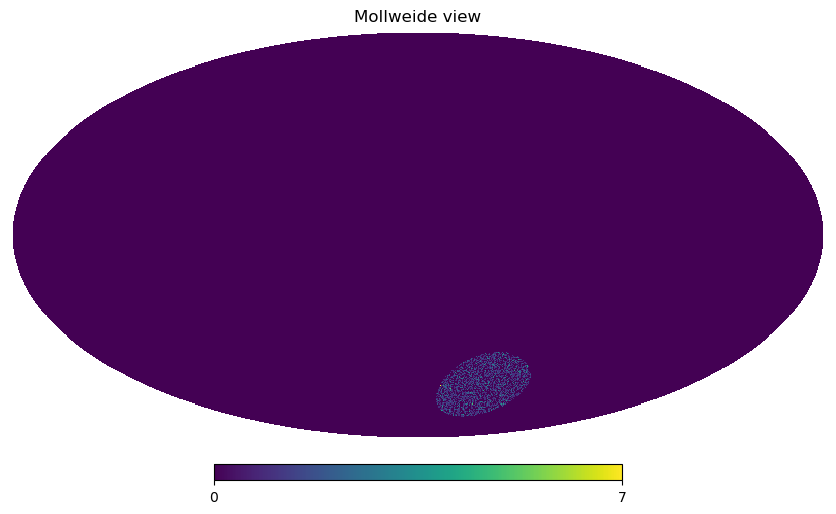

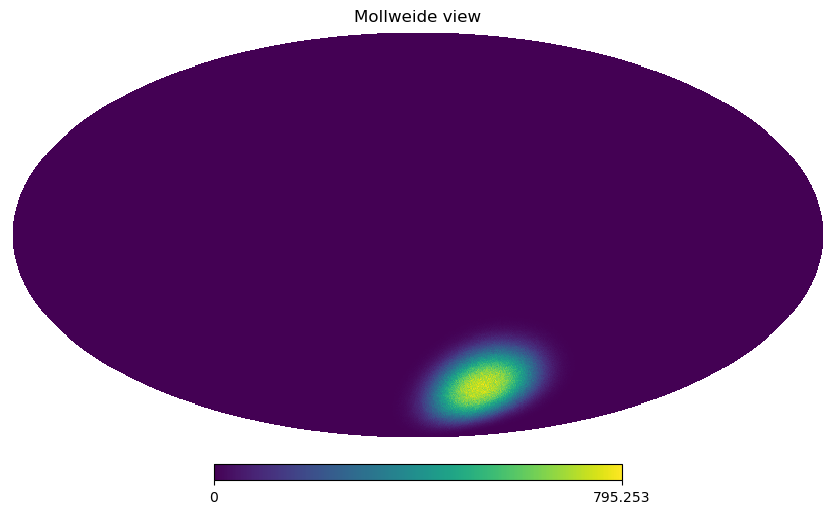

In [18]:
ipixel = sampling_test.healpix(nside_sky)
npixel = 12 * nside_sky ** 2
hit = np.histogram(ipixel, bins=npixel, range=(0, npixel))[0]
hp.mollview(hit)
hp.mollview(coverage)

In [19]:
rho_hp_v2 = np.zeros(npixel)
for i in range(len(ipixel)):
    rho_hp_v2[int(ipixel[i])] = get_atm_value_2d(rho_2d, np.radians(azimuth[i]), np.radians(elevation[i]), x_list, y_list, Lz)[2]

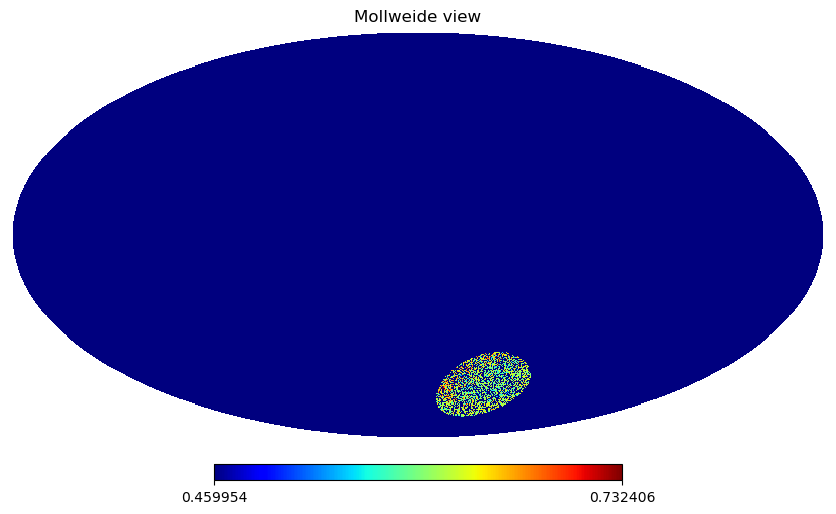

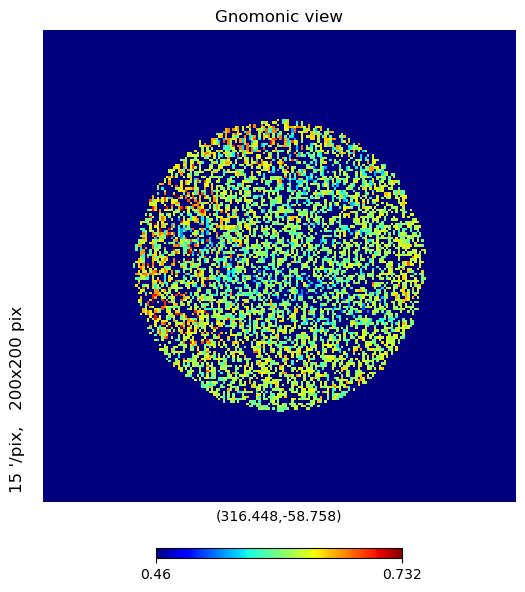

In [20]:
hp.mollview(rho_hp_v2, min=np.min(rho_2d), cmap='jet')
hp.gnomview(rho_hp_v2, rot=qubic.equ2gal(center[0], center[1]), reso=15, min=np.min(rho_2d), cmap='jet')

# RADEC Projection V3

Je refais à la main les étapes de sampling.py. Méthode la plus aboutie mais je n'arrive pas à savoir si le résultat obtenu a du sens

J'interprète le résultat comme : on observe une atmosphère fixe en RADEC avec une scanning strategy random. 
Mais du fait de la rotation de la Terre, le résultat obtenu ne ressemble à rien.
Je ne supprime pas pour garder une trace de ça.

In [21]:
pointing = 20000
p = QubicSampling(pointing, date_obs=d['date_obs'], period=1, latitude=d['latitude'], longitude=d['longitude'])

r = np.random.RandomState(2)

cosdtheta = np.cos(np.radians(20))
theta = np.degrees(np.arccos(cosdtheta + (1 - cosdtheta) * r.rand(pointing)))
phi = r.rand(pointing) * 360
pitch = r.rand(pointing) * 360

time = p.date_obs + TimeDelta(p.time, format='sec')
c2s = Cartesian2SphericalOperator('azimuth,elevation', degrees=True)
e2h = CartesianEquatorial2HorizontalOperator(
    'NE', time, p.latitude, p.longitude)
rot = Rotation3dOperator("ZY'", center[0], 90 - center[1], degrees=True)
s2c = Spherical2CartesianOperator('zenith,azimuth', degrees=True)
rotation = c2s(e2h(rot(s2c)))
coords = rotation(np.asarray([theta, phi]).T)
azimuth = coords[..., 0]
elevation = coords[..., 1]


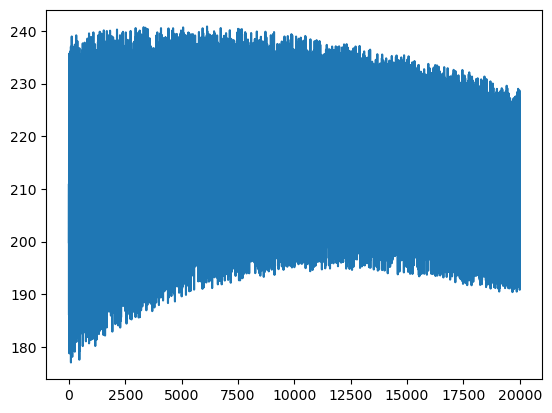

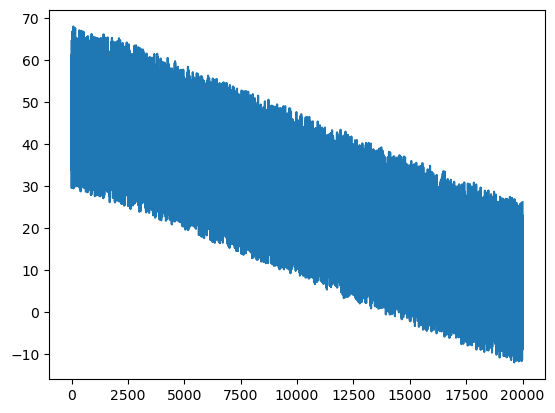

In [22]:
plt.plot(azimuth)
plt.show()
plt.plot(elevation)

In [23]:
x_atm, y_atm = azel_to_horizontal_plane(azimuth, elevation, Lz*np.ones(pointing))

In [24]:
i=np.where(x_atm<-1*1e8)
print(elevation[i], azimuth[i])

[] []


In [25]:
azel_to_horizontal_plane(186, 26, Lz)

(-677.3918399259394, -510.7292660174921)

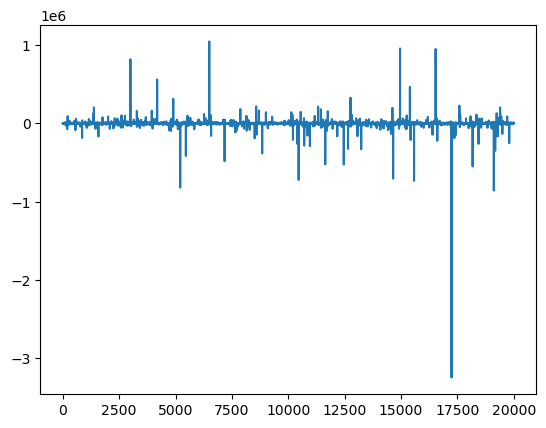

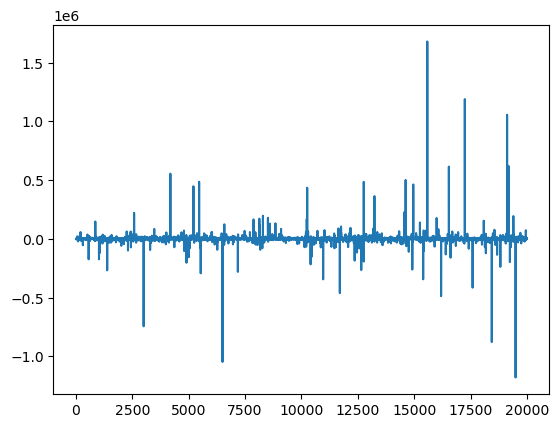

In [26]:
plt.plot(x_atm)
plt.show()
plt.plot(y_atm)

In [27]:
c2h = Cartesian2HealpixOperator(nside_sky)
e2g = CartesianEquatorial2GalacticOperator()
h2e = CartesianHorizontal2EquatorialOperator(
    'NE', time, p.latitude, p.longitude)
rotation_spherical2hp = c2h(e2g(h2e(Spherical2CartesianOperator('azimuth,elevation', degrees=True))))

In [28]:
b = rotation_spherical2hp(np.asarray([azimuth, elevation]).T)

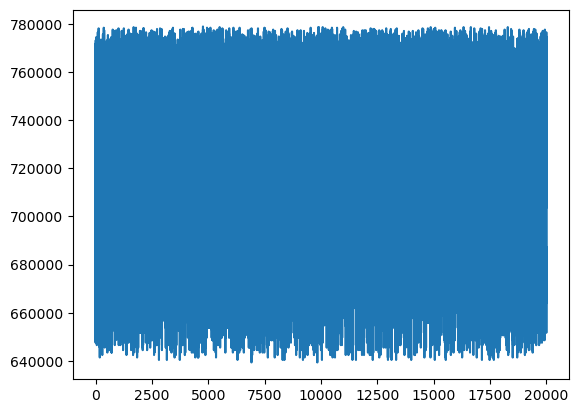

In [29]:
plt.plot(b)

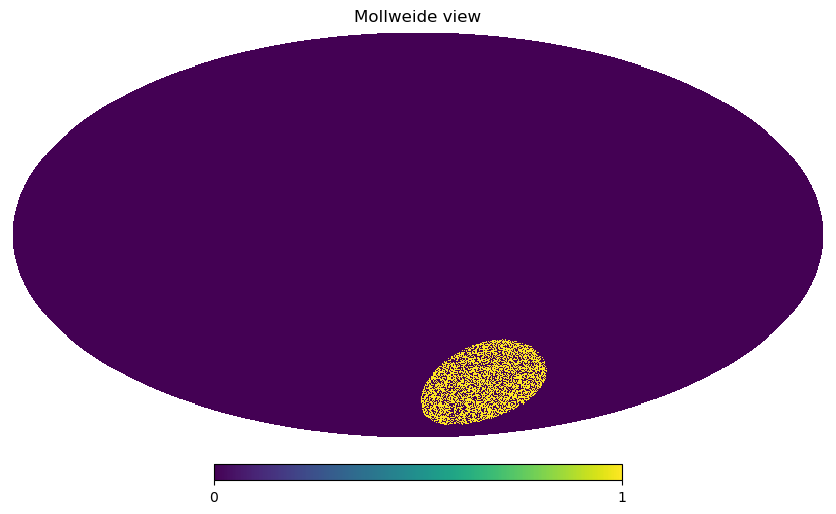

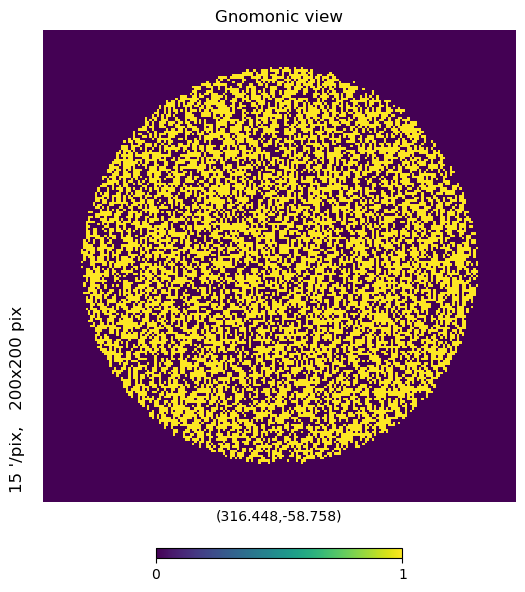

In [30]:
test=np.zeros(npixel)
for i in range(pointing):
    test[int(b[i])] = 1
hp.mollview(test)
hp.gnomview(test, rot=qubic.equ2gal(center[0], center[1]), reso=15)

In [31]:
e2h = CartesianEquatorial2HorizontalOperator(
    'NE', time, p.latitude, p.longitude)
rot = Rotation3dOperator("ZY'", center[0], 90 - center[1], degrees=True)
s2c = Spherical2CartesianOperator('zenith,azimuth', degrees=True)
rotation_spherical2radec = Cartesian2SphericalOperator('zenith, azimuth')((rot(s2c)))

In [32]:
radec = rotation_spherical2radec(np.asarray([theta.T, phi.T]).T)

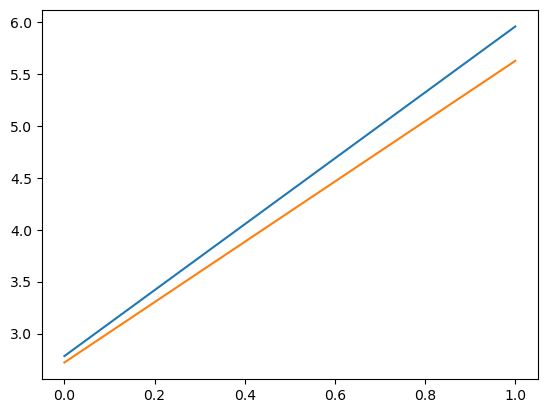

In [33]:
plt.plot(radec[0])
plt.plot(radec[1])

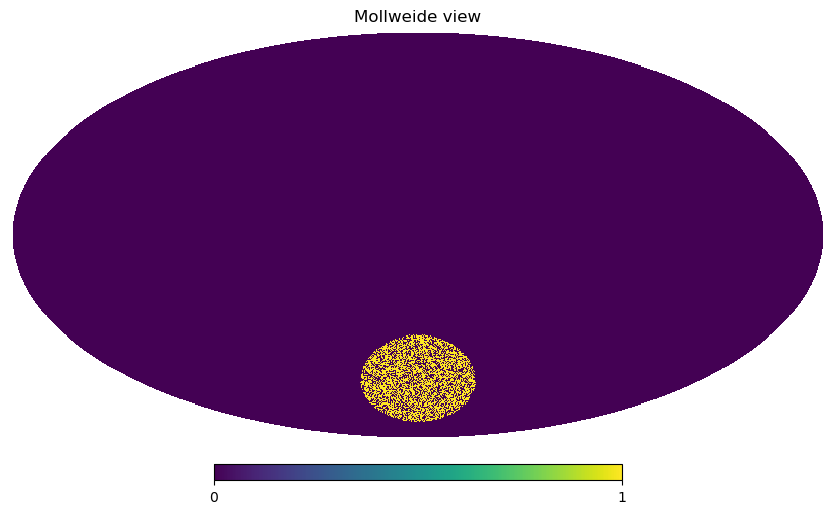

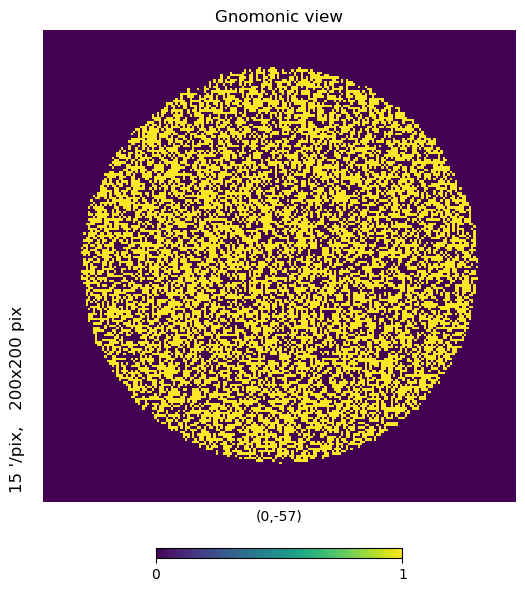

In [34]:
test=np.zeros(npixel)
test[hp.ang2pix(nside_sky, radec[:,0], radec[:, 1])] = 1
hp.mollview(test)
hp.gnomview(test, rot=center, reso=15)

In [35]:
azimuth = coords[:, 0]
elevation = coords[:, 1]
rho_hp_v3 = np.zeros(npixel)
cpt=0
for i in range(len(azimuth)):
    x_atm, y_atm = azel_to_horizontal_plane(azimuth[i], elevation[i], Lz)
    if -L<x_atm<L and -L<y_atm<L:
        ind_x, x_pos = find_closest_element(x_list, x_atm)
        ind_y, y_pos = find_closest_element(y_list, y_atm)
        cpt += 1            
        rho_hp_v3[int(b[i])] = rho_2d[ind_y, ind_x]
        #rho_hp_v3[hp.ang2pix(nside_sky, radec[i,0], radec[i,1])] = rho_2d[ind_y, ind_x]
print(cpt, ' points in the atm')
            

18924  points in the atm


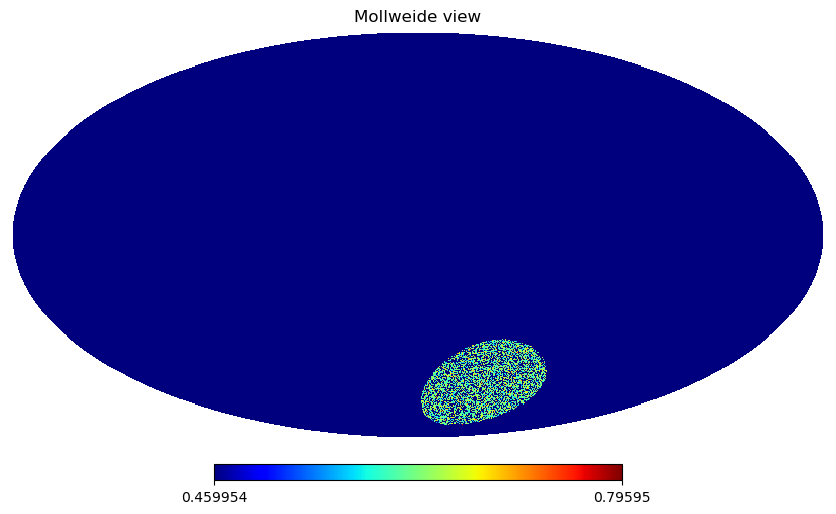

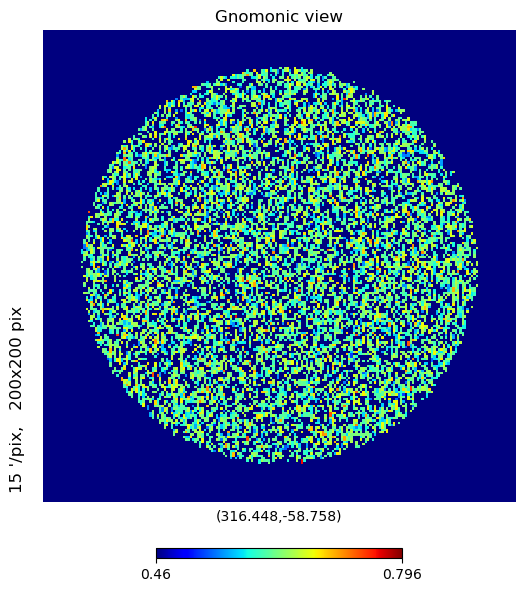

In [36]:
hp.mollview(rho_hp_v3, min=np.min(rho_2d), max=np.max(rho_2d), cmap='jet')
hp.gnomview(rho_hp_v3, rot=qubic.equ2gal(center[0], center[1]), reso=15, min=np.min(rho_2d), max=np.max(rho_2d), cmap='jet')

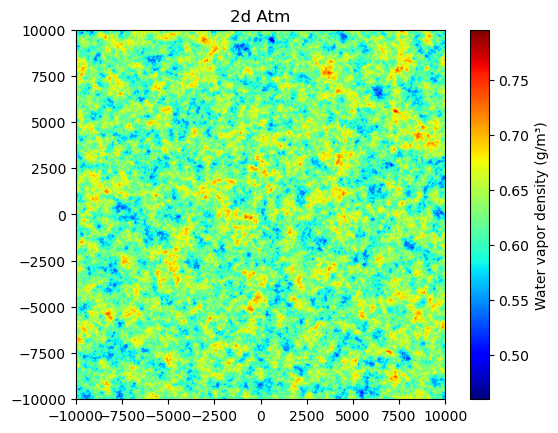

In [37]:
plt.figure()
plt.imshow(rho_2d, extent=[-L, L, -L, L], cmap='jet')
plt.title('2d Atm')
plt.colorbar(format = '%.2f', label = 'Water vapor density (g/m³)')
plt.show()

# RADEC Projection V4

In [38]:
def horizontal_plane_to_azel(x,y,z):
    rho = np.sqrt(x**2 + y**2 + z**2)
    el = np.pi/2 - np.arccos(z/rho)
    az = np.arctan2(y, x)
    return az, el

def horizontal_plane_to_spherical(x, y, z):
    rho = np.sqrt(x**2 + y**2 + z**2)
    el = - np.arccos(z/rho)
    az = np.arctan2(y, x)
    return az, el

In [39]:
az_list, el_list = [], []
theta_list, phi_list = [], []
atm_value = []
for ind_x in range(len(x_list)):
    for ind_y in range(len(y_list)):
        azel = horizontal_plane_to_azel(x_list[ind_x], y_list[ind_y], Lz)
        spherical = horizontal_plane_to_spherical(x_list[ind_x], y_list[ind_y], Lz)
        az_list.append(azel[0])
        el_list.append(azel[1])
        atm_value.append(rho_2d[ind_x, ind_y])
        theta_list.append(spherical[0])
        phi_list.append(spherical[1])

ATTENTION !!!!! VÉRIFIER QUE ('AZIMUTH,ELEVATION') DESIGNE BIEN AZIMUTH, ÉLEVATION DE L'INSTRUMENT ET PAS DES COORDONNÉES SUR LA SPHÈRE

In [40]:
rota = Cartesian2SphericalOperator('azimuth,zenith')(Rotation3dOperator("ZY'", d['latitude'], d['longitude'])(Spherical2CartesianOperator('azimuth,elevation')))
azel2thetaphi = Cartesian2SphericalOperator('zenith, azimuth')(Spherical2CartesianOperator('azimuth,elevation'))

In [41]:
rotation_spherical2hp = Spherical2HealpixOperator(nside_sky,'azimuth,zenith')
rotation_azel2hp = Spherical2HealpixOperator(nside_sky, 'azimuth,elevation')

In [42]:
thetaphi = rota(np.asarray([az_list, el_list]).T)
theta = thetaphi[...,0]
phi = thetaphi[...,1]

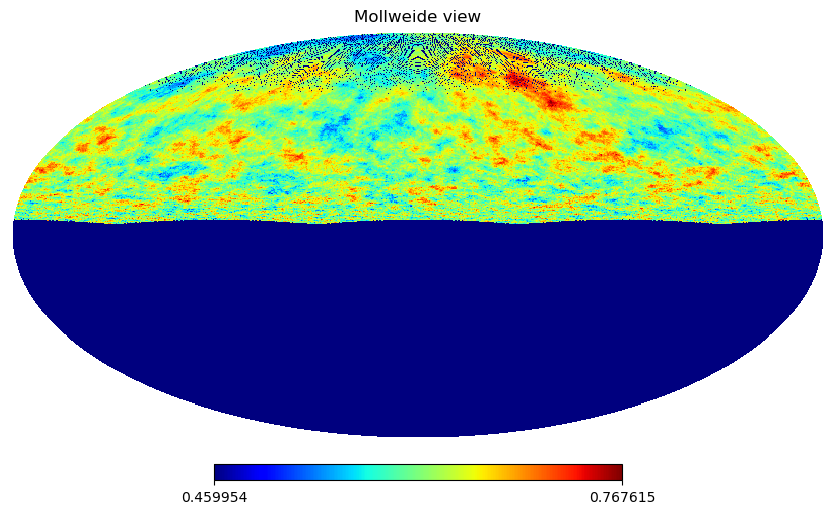

In [43]:
hp_map = rotation_azel2hp(np.asarray([az_list, el_list]).T)
test=np.zeros(npixel)
for ind in range(len(hp_map)):
    test[int(hp_map[ind])] = atm_value[ind]
hp.mollview(test, cmap='jet', min=np.min(rho_2d))

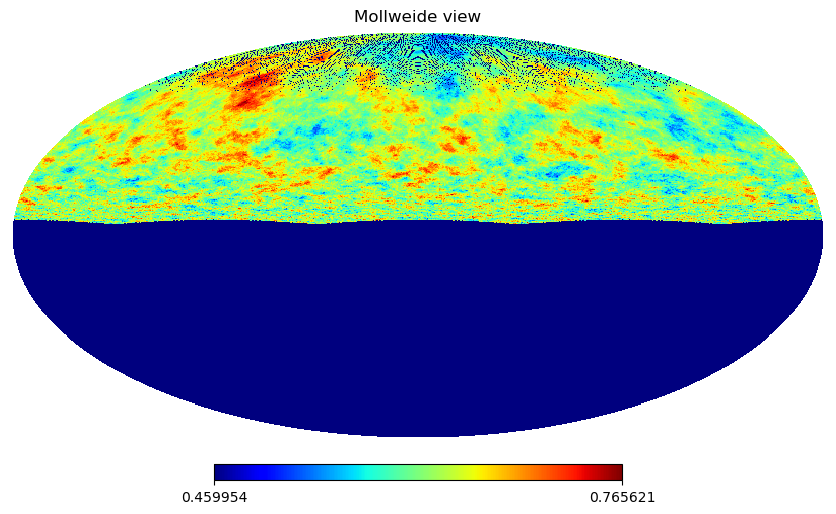

In [44]:
hp_map = rotation_spherical2hp(np.asarray([theta_list, phi_list]).T)
test=np.zeros(npixel)
for ind in range(len(hp_map)):
    test[int(hp_map[ind])] = atm_value[ind]
hp.mollview(test, cmap='jet', min=np.min(rho_2d))

Projection au-dessus de QUBIC

In [45]:
x_list.shape

(4000,)

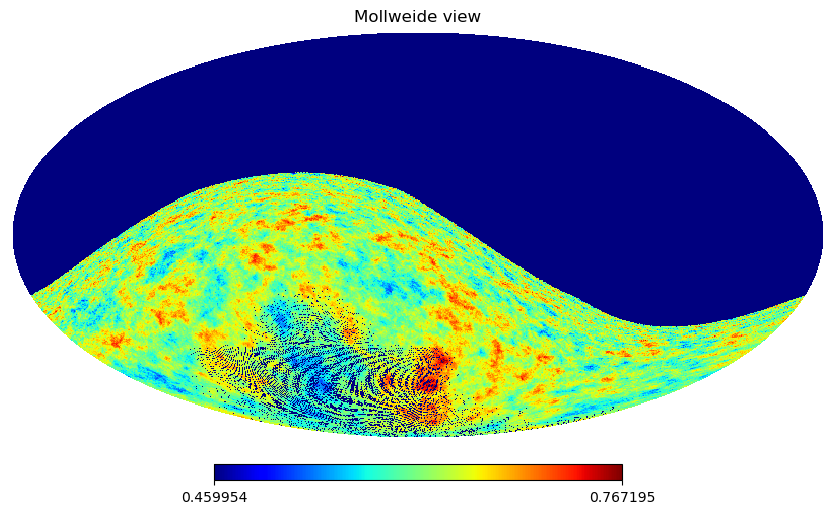

In [46]:
hp_map = rotation_spherical2hp(rota(np.asarray([az_list, el_list]).T))
test=np.zeros(npixel)
for ind in range(len(hp_map)):
    test[int(hp_map[ind])] = atm_value[ind]
hp.mollview(test, cmap='jet', min=np.min(rho_2d))

Pas sûr de ce que je fais ici... Je pense que ça revient à projeter l'atmopshère dans le ciel, et l'observer depuis la Terre en rotation.
Mais, ça n'a pas beaucoup de sens de faire ça car l'atm n'existe que sur Terre.
Il vaut peut-être mieux garder uniquement la carte précédente et appliquer le vent sur elle à chaque instant.

In [47]:
# hp_test = []
# for i in range(10):
#     p = QubicSampling(len(hp_map), date_obs=f'2016-01-01 0{i}:00:00', period=0, latitude=d['latitude'], longitude=d['longitude'])
#     time = p.date_obs + TimeDelta(p.time, format='sec')
#     rota = Cartesian2SphericalOperator('azimuth,zenith')(Rotation3dOperator("ZY'", d['longitude'], d['latitude'])(CartesianEquatorial2HorizontalOperator('NE', time, d['latitude'], d['longitude'])(Spherical2CartesianOperator('azimuth,elevation'))))
#     sph2hp = Spherical2HealpixOperator(nside_sky, 'azimuth,elevation')
#     hp_test.append(rotation_spherical2hp(rota(np.asarray([az_list, el_list]).T)))
# for i in range(10):
#     test=np.zeros(npixel)
#     for ind in range(len(hp_test[i])):
#         test[int(hp_test[i][ind])] = atm_value[ind]
#     hp.mollview(test, cmap='jet', min=np.min(rho_2d))

# Projection (az, el)

In [48]:
p = QubicSampling(pointing, date_obs=d['date_obs'], period=1, latitude=d['latitude'], longitude=d['longitude'])

r = np.random.RandomState(2)

cosdtheta = np.cos(np.radians(20))
theta = np.degrees(np.arccos(cosdtheta + (1 - cosdtheta) * r.rand(pointing)))
phi = r.rand(pointing) * 360
pitch = r.rand(pointing) * 360

time = p.date_obs + TimeDelta(p.time, format='sec')
c2s = Cartesian2SphericalOperator('azimuth,elevation', degrees=True)
e2h = CartesianEquatorial2HorizontalOperator(
    'NE', time, p.latitude, p.longitude)
rot = Rotation3dOperator("ZY'", center[0], 90 - center[1], degrees=True)
s2c = Spherical2CartesianOperator('zenith,azimuth', degrees=True)
rotation = c2s(e2h(rot(s2c)))
coords = rotation(np.asarray([theta, phi]).T)
azimuth_qubic = coords[..., 0] - 180
elevation_qubic = coords[..., 1]

In [49]:
CartesianEquatorial2HorizontalOperator??

Init signature:
CartesianEquatorial2HorizontalOperator(
    convention,
    time,
    latitude,
    longitude,
    **keywords,
)
Source:        
class CartesianEquatorial2HorizontalOperator(_CartesianEquatorialHorizontal):
    """
    Conversion between equatorial-to-horizontal cartesian coordinates.

    The ICRS equatorial direct referential is defined by:
        - the Earth center as the origin
        - the vernal equinox of coordinates (1, 0, 0)
        - the Earth North pole of coordinates (0, 0, 1)

    The horizontal referential is defined by:
        - the observer geographic position as the origin
        - the azimuth reference (North or South) of coordinates (1, 0, 0)
        - whether the azimuth is measured towards the East or West
        - the zenith of coordinates (0, 0, 1)

    Example
    -------
    >>> from astropy.time import Time, TimeDelta
    >>> t0 = Time(['2000-01-01 00:00:00.0'], scale='utc')
    >>> dt = TimeDelta(np.arange(1000)/10, format='sec')
    >>> 

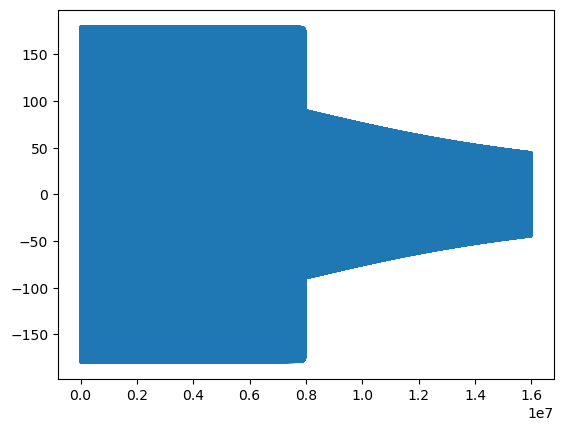

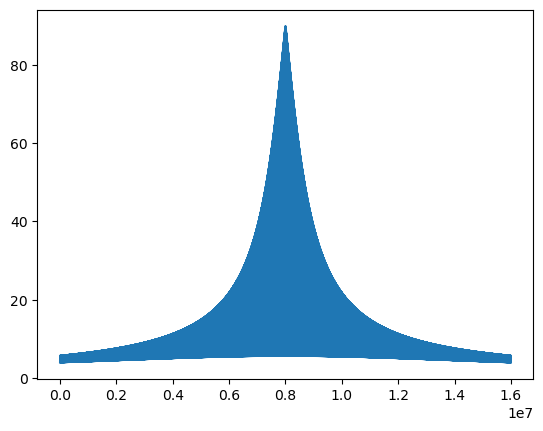

In [50]:
plt.plot(np.degrees(az_list))
plt.show()
plt.plot(np.degrees(el_list))

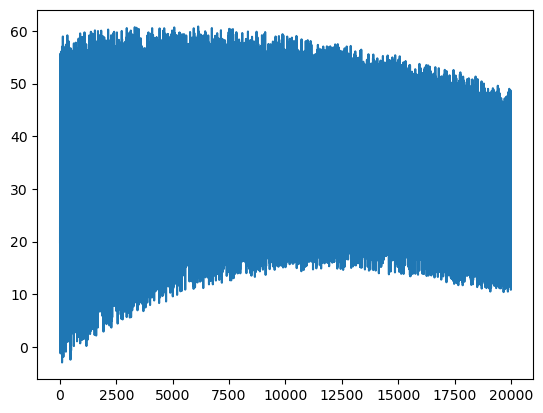

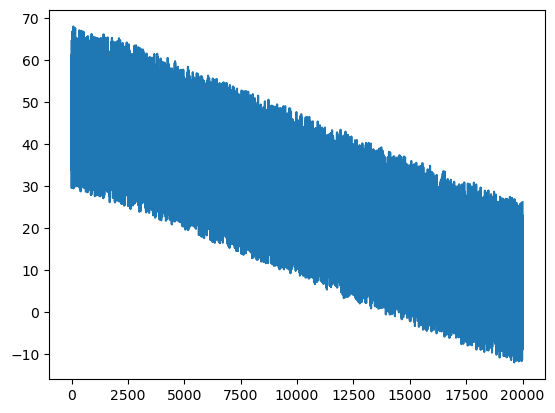

In [51]:
plt.plot(azimuth_qubic)
plt.show()
plt.plot(elevation_qubic)

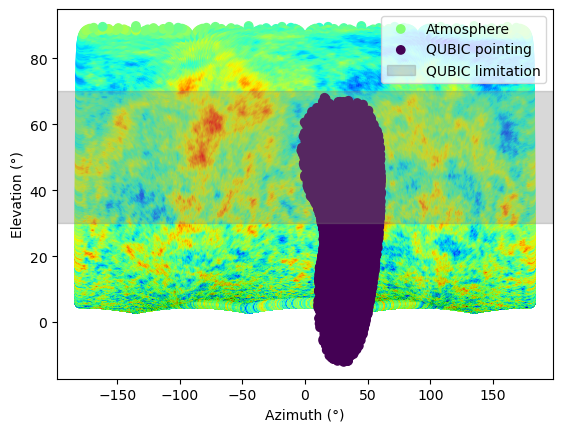

In [52]:
plt.scatter(np.degrees(az_list), np.degrees(el_list), c=atm_value, cmap='jet', label='Atmosphere')
plt.scatter(azimuth_qubic, elevation_qubic, c=np.ones(len(azimuth_qubic)), label='QUBIC pointing')
plt.axhspan(30, 70, color='gray', alpha=0.3, label="QUBIC limitation")
plt.xlabel('Azimuth (°)')
plt.ylabel('Elevation (°)')
plt.legend()

In [53]:
stop

NameError: name 'stop' is not defined

: 

# QUBIC TOD

In [ ]:
#Choose : rho_hp_v0, rho_hp, rho_hp_v2, rho_hp_v3, rho_hp_v4
rho = test

In [ ]:
atm_maps = np.zeros((2, npixel, 3))
atm_maps[..., 0] = np.array(rho)

In [ ]:
A = H.T * H
b = H.T * H(atm_maps)
x0 = atm_maps + 1e-3 * np.random.randn(2, atm_maps.shape[1], 3)
M =_get_preconditionner()

In [ ]:
import time
time0 = time.time()
algo = cg.PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-18,
    maxiter=50,
    disp=True,
    M=M,
    create_gif=False,
    center=center,
    reso=params['QUBIC']['dtheta'],
    seenpix=seenpix,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

   1: 2.1272e-04 5.68022
   2: 9.0820e-05 5.62530
   3: 7.7956e-05 5.62895
   4: 7.5607e-05 5.61836
   5: 4.5919e-05 5.62243
   6: 4.3449e-05 5.63129
   7: 4.2987e-05 5.65844
   8: 3.0386e-05 5.84944
   9: 2.4285e-05 5.62861
  10: 2.1675e-05 5.62571
  11: 1.8942e-05 5.63230
  12: 1.6845e-05 5.68174
  13: 1.5565e-05 5.89129
  14: 1.4110e-05 5.90687
  15: 1.2658e-05 5.76995
  16: 1.1496e-05 5.62256
  17: 1.1387e-05 5.63000
  18: 1.6888e-05 5.62828
  19: 1.0281e-05 5.62196
  20: 9.3332e-06 5.64277
  21: 8.6235e-06 5.62692
  22: 8.3081e-06 5.62501
  23: 7.6027e-06 5.61999
  24: 7.2476e-06 5.62554
  25: 6.8330e-06 5.71948
  26: 6.5304e-06 5.71767
  27: 6.1100e-06 5.60474
  28: 5.9844e-06 5.64245
  29: 6.5291e-06 5.62985
  30: 6.8367e-06 5.63688
  31: 5.4001e-06 5.61865
  32: 5.0209e-06 5.67526
  33: 6.1761e-06 5.85072
  34: 6.3189e-06 5.73775
  35: 6.2491e-06 5.61849
  36: 4.9244e-06 5.62357
  37: 4.3882e-06 5.62095
  38: 4.2305e-06 5.61594
  39: 4.2275e-06 5.59844
  40: 3.9778e-06 5.67729


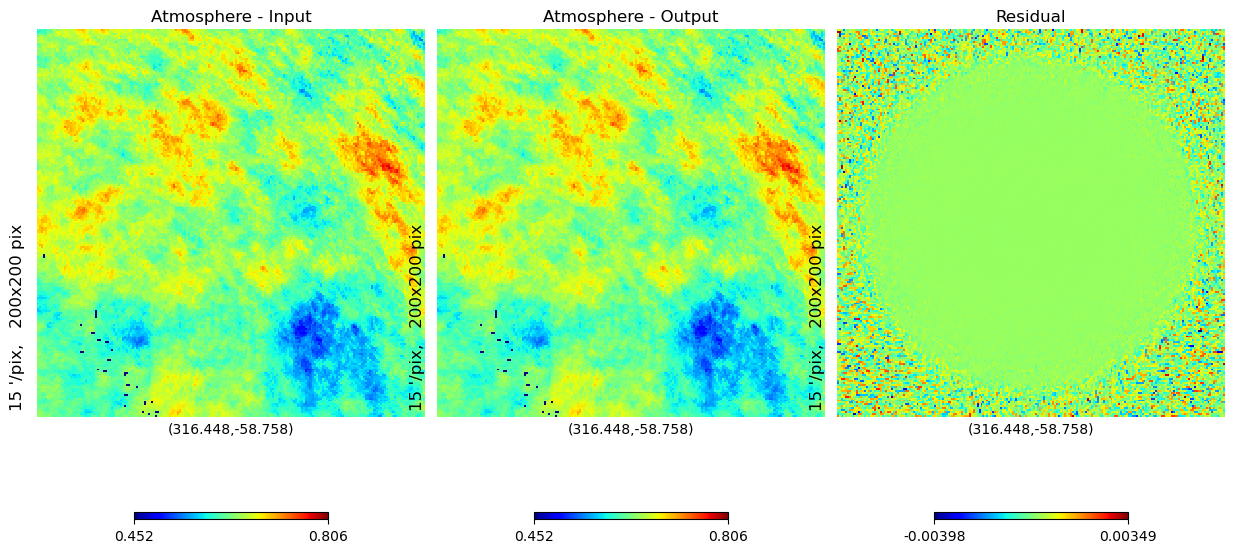

In [ ]:
solution = output['x']

plt.figure(figsize=(12, 12))
hp.gnomview(rho, rot=qubic.equ2gal(center[0], center[1]), min=np.min(rho_2d), max=np.max(rho_2d), reso=15, cmap='jet', sub=(1, 3, 1), title="Atmosphere - Input")
hp.gnomview(solution[0, :, 0], min=np.min(rho_2d), max=np.max(rho_2d), rot=qubic.equ2gal(center[0], center[1]), reso=15, cmap='jet', sub=(1, 3, 2), title='Atmosphere - Output')
hp.gnomview(rho - solution[0, :, 0], rot=qubic.equ2gal(center[0], center[1]), reso=15, cmap='jet', sub=(1, 3, 3), title='Residual')

In [ ]:
rho_2d_flatten = rho_2d.flatten()
map_healpy = hp.mollview(rho_2d_flatten, cmap='jet', return_projected_map=True)

TypeError: bad number of pixels

In [ ]:
atm_maps = np.zeros((2, len(rho_2d_flatten), 3))
atm_maps[..., 0] = np.array(rho_2d_flatten)

In [ ]:
np.array(rho_2d_flatten).shape

(786432,)

In [ ]:
atm_maps[..., 1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
H(atm_maps)

array([[8.89141818e-21, 8.51493889e-21, 8.64933464e-21, ...,
        8.75329881e-21, 8.84816096e-21, 8.76613591e-21],
       [8.65457663e-21, 8.32150846e-21, 8.43992493e-21, ...,
        8.62381870e-21, 8.69735121e-21, 8.73556848e-21],
       [8.43185995e-21, 8.13251347e-21, 8.24934158e-21, ...,
        8.28186028e-21, 8.25461007e-21, 8.42782814e-21],
       ...,
       [2.42220182e-20, 2.35504589e-20, 2.34497485e-20, ...,
        2.37875209e-20, 2.35457025e-20, 2.43928561e-20],
       [1.88123376e-20, 1.84815796e-20, 1.86812646e-20, ...,
        1.86703272e-20, 1.87200976e-20, 1.94390226e-20],
       [1.48229512e-20, 1.43883440e-20, 1.46790606e-20, ...,
        1.48918123e-20, 1.47691675e-20, 1.53261283e-20]])

 ...]

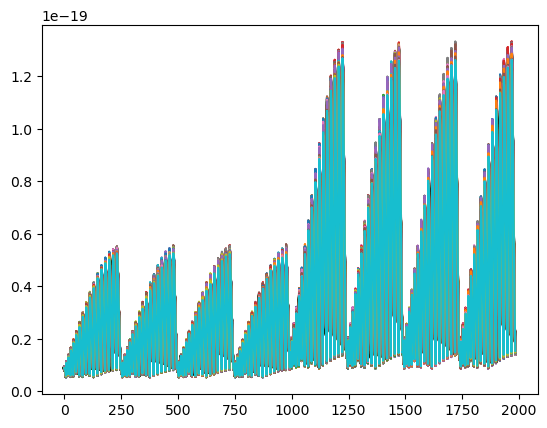

In [ ]:
plt.plot(H(atm_maps))

In [ ]:
np.shape(atm_maps)

(2, 786432, 3)

In [ ]:
A = H.T * H
b = H.T * H(atm_maps)
x0 = atm_maps + 1e-1 * np.random.randn(2, atm_maps.shape[1], 3)
M =_get_preconditionner()

In [ ]:
M

DiagonalOperator(array([[[1.0, ..., 1.0]]], dtype=float64), broadcast='rightward', None)

In [ ]:
time0 = time.time()
algo = cg.PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-18,
    maxiter=100,
    disp=True,
    M=M,
    create_gif=False,
    center=center,
    reso=params['QUBIC']['dtheta'],
    seenpix=seenpix,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

   1: 2.0640e-02 1.42932
   2: 9.8968e-03 1.59164
   3: 8.2599e-03 1.47463
   4: 7.6816e-03 1.47397
   5: 4.8786e-03 1.44554
   6: 4.1114e-03 1.52347
   7: 3.5640e-03 1.48922
   8: 3.8219e-03 1.52689
   9: 2.6505e-03 1.49624
  10: 2.2829e-03 1.69903
  11: 1.9765e-03 1.66577


KeyboardInterrupt: 

In [ ]:
solution = output['x']

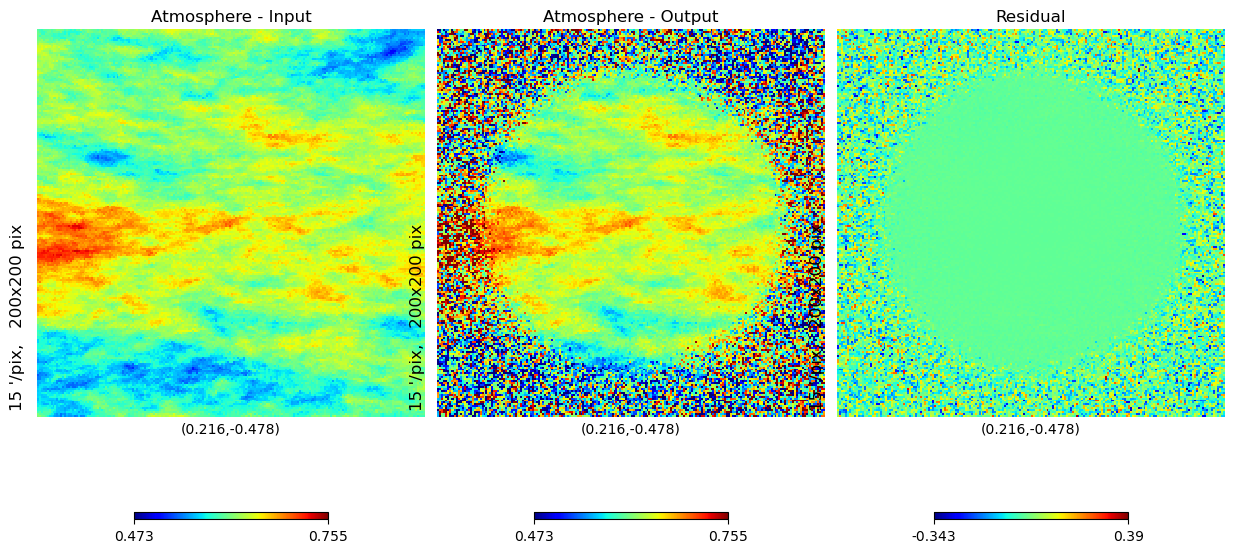

In [ ]:
solution = output['x']

plt.figure(figsize=(12, 12))
hp.gnomview(rho_2d_flatten, rot=center, min=np.min(rho_2d_flatten), max=np.max(rho_2d_flatten), reso=15, cmap='jet', sub=(1, 3, 1), title="Atmosphere - Input")
hp.gnomview(solution[0, :, 0], min=np.min(rho_2d_flatten), max=np.max(rho_2d_flatten), rot=center, reso=15, cmap='jet', sub=(1, 3, 2), title='Atmosphere - Output')
hp.gnomview(rho_2d_flatten - solution[0, :, 0], rot=center, reso=15, cmap='jet', sub=(1, 3, 3), title='Residual')

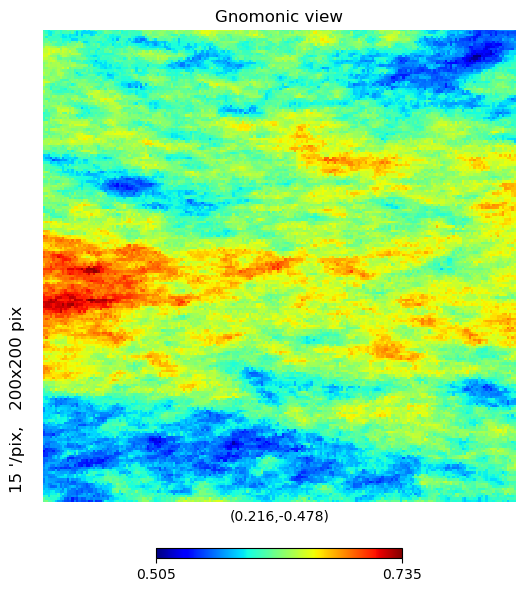

In [ ]:
hp.gnomview(rho_2d_flatten, rot=center, reso=15, cmap='jet')

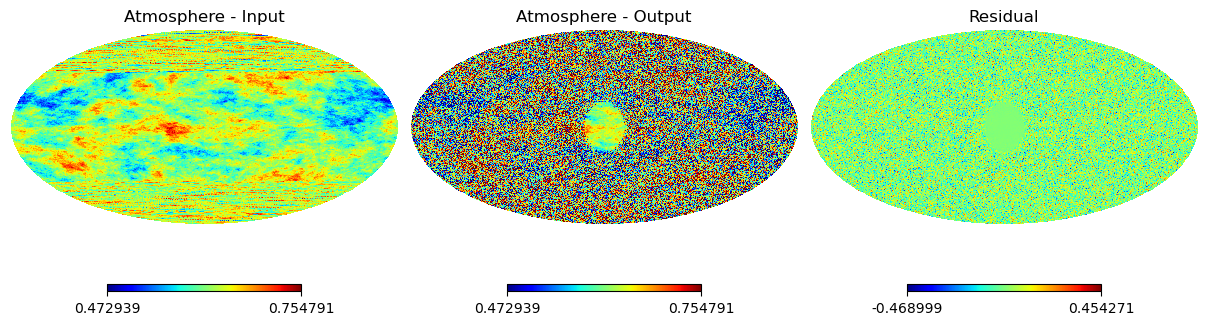

In [ ]:
plt.figure(figsize=(12, 12))
hp.mollview(rho_2d_flatten, cmap='jet', min=np.min(rho_2d_flatten), max=np.max(rho_2d_flatten), sub=(1, 3, 1), title="Atmosphere - Input")
hp.mollview(solution[0, :, 0], cmap='jet', min=np.min(rho_2d_flatten), max=np.max(rho_2d_flatten), sub=(1, 3, 2), title='Atmosphere - Output')
hp.mollview(rho_2d_flatten - solution[0, :, 0], cmap='jet', sub=(1, 3, 3), title='Residual')

In [ ]:
atm_maps.shape

(2, 786432, 3)

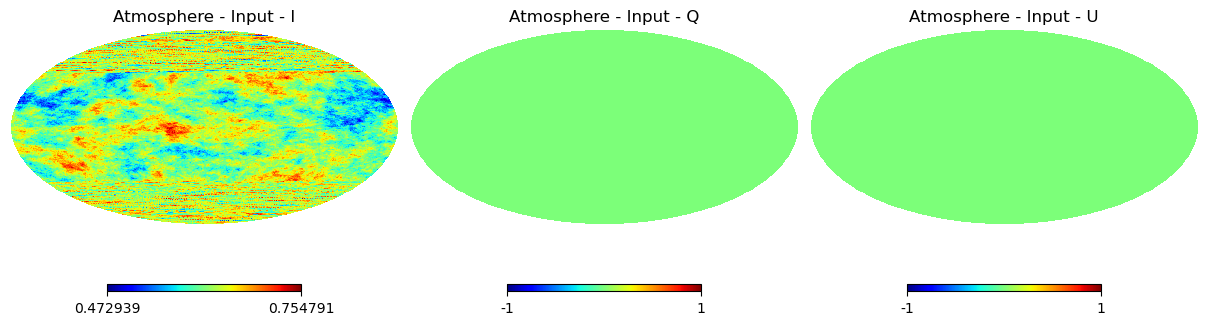

In [ ]:
plt.figure(figsize=(12, 12))
hp.mollview(atm_maps[0, :, 0], cmap='jet', sub=(1, 3, 1), title="Atmosphere - Input - I")
hp.mollview(atm_maps[0, :, 1], cmap='jet', sub=(1, 3, 2), title='Atmosphere - Input - Q')
hp.mollview(atm_maps[0, :, 2], cmap='jet', sub=(1, 3, 3), title='Atmosphere - Input - U')

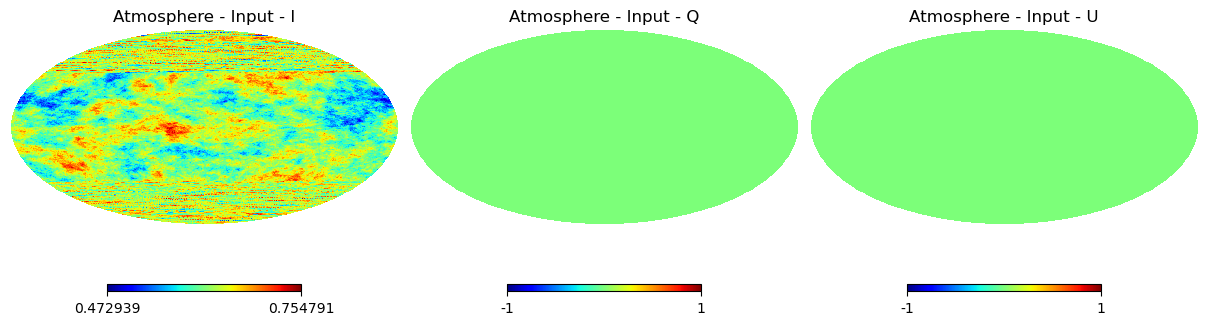

In [ ]:
plt.figure(figsize=(12, 12))
hp.mollview(atm_maps[1, :, 0], cmap='jet', sub=(1, 3, 1), title="Atmosphere - Input - I")
hp.mollview(atm_maps[1, :, 1], cmap='jet', sub=(1, 3, 2), title='Atmosphere - Input - Q')
hp.mollview(atm_maps[1, :, 2], cmap='jet', sub=(1, 3, 3), title='Atmosphere - Input - U')